In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 扩展卡尔曼滤波（Extended Kalman Filter，EKF）

在卡尔曼滤波中，要满足两个条件：观测是状态的线性函数，下一个状态是当前状态的线性函数。这两个假设对KF的正确性是很重要的。

不幸的是，实际上状态转移函数和测量函数很少是线性函数。例如具有恒定线速度和角速度的机器人的典型移动轨迹是圆。对于这种情况有两种方案：
1. 将状态转移函数和测量函数进行线性化，利用参数化的分布来保存不确定性。
2. 利用非参数的方法，例如直方图或粒子集的方法来保存分布的不确定性。

## 1. 扩展卡尔曼滤波算法

### 1.1 非线性的状态转移函数和测量函数

令非线性的状态转移函数为：
$$x_t = g(u_t, x_{t-1} ) + \varepsilon_t$$

非线性的观测函数为：
$$z_t = h(x_t) + \delta_t$$

准确的实现置信度更新对于非线性函数$g$和$h$通常是不可能的，贝叶斯滤波不存在闭式解。EKF计算**真实置信度的高斯近似值**，因此EKF表示时刻$t$的置信度$bel(x_t)$，具有均值$\mu_t$和协方差$\Sigma_t$。

### 1.2 通过泰勒展式进行线性化

泰勒展开根据$g$的值和斜率构造一个函数$g$的线性近似函数，斜率由下面的偏导数给出：
$$G_t = g'(u_t, x_{t-1}) := \frac {\partial g(u_t, x_{t-1})}{\partial x_{t-1}}$$
$G_t$是函数$g$的Jacobian。

用相同的方法可以求得测量函数的Jacobian：
$$H_t = h'(x_t) = \frac {\partial h(x_t)}{\partial x_t}$$

### 1.3 扩展卡尔曼滤波算法

----
1：**Algorithm Extended_Kalman_filter**$( \mu_{t-1}, \Sigma_{t-1}, u_t, z_t )$**:**  
2：&emsp;&emsp;$\overline \mu_t = g(u_t, \mu_{t-1})$  
3：&emsp;&emsp;$\overline \Sigma_t = G_t \Sigma_{t-1}G_t^T + R_t$  
4：&emsp;&emsp;$K_t = \overline \Sigma_t H_t^T ( H_t \overline \Sigma_t H_t^T + Q_t)^{-1}$  
5：&emsp;&emsp;$\mu_t = \overline \mu_t + K_t (z_t - h(\overline \mu_t))$  
6：&emsp;&emsp;$\Sigma_t = (I - K_t H_t) \overline \Sigma_t$  
7：&emsp;&emsp;**return** ${\mu_t, \Sigma_t}$  

----

## 2. 仿真模型

假定有一个在平面环境操作的移动机器人，其状态是它的$(x,y)^T$位置和它的全局航向$\theta$。假定已知确切的$x$和$y$，但是方向$\theta$是未知的。例如初始的估计为：
$$\mu = (0, 0, \frac {\pi}{4}) \qquad \Sigma = \begin{bmatrix}
0.01 & 0 & 0 \\ 0 & 0.01 & 0 \\ 0 & 0 & 10000
\end{bmatrix}$$

假设机器人的运动控制是向前移动$u_t$个单位，因此移动后机器人的期望位置将为：
$$\begin{bmatrix}
x' \\ y' \\ \theta'
\end{bmatrix} = \begin{bmatrix}
x + u_t cos \theta \\ y + u_t sin \theta \\ \theta
\end{bmatrix}$$

测量量是机器人距离世界坐标系原点的距离。
$$z_t = h(x_t) = \sqrt{x^2 + y^2} $$

### 2.1 状态转移函数的定义

In [2]:
def state_transfer_function(mu, u):
    x0, y0, theta0 = np.squeeze(mu)
    x1 = x0 + u * np.cos(theta0)
    y1 = y0 + u * np.sin(theta0)
    theta1 = theta0
    return np.array([x1, y1, theta1]).reshape((3, 1))

state_transfer_function(np.array([0, 0, np.pi / 6]).reshape((3, 1)),5)

array([[ 4.33012702],
       [ 2.5       ],
       [ 0.52359878]])

### 2.2 测量函数的定义

In [3]:
def measurement_function(mu):
    x0, y0, theta0 = np.squeeze(mu)
    z = np.sqrt(x0 ** 2 + y0 ** 2)
    return np.array([z]).reshape((1,1))

measurement_function(np.array([3, 4, np.pi / 6]).reshape((3, 1)))

array([[ 5.]])

### 2.3 状态转移采样函数（带噪声）

In [4]:
def state_transfer_sample(mu, u, Sigma_u):
    x0, y0, theta0 = np.squeeze(mu)
    noise_x, noise_y, noise_theta = np.random.multivariate_normal(np.zeros(3), Sigma_u)
    x1 = x0 + noise_x + u * np.cos(theta0 + noise_theta)
    y1 = y0 + noise_y + u * np.sin(theta0 + noise_theta)
    theta1 = theta0 + noise_theta
    return np.array([x1, y1, theta1]).reshape((3, 1))

Sigma = np.diag([0.2**2, 0.2 ** 2, 0.05 ** 2])
state_transfer_sample(np.array([0, 0, np.pi / 6]).reshape((3, 1)), 5, Sigma)

array([[ 4.21844835],
       [ 2.25873565],
       [ 0.49521623]])

### 2.4 测量采样函数（带噪声）

In [5]:
def measurement_sample(mu, Sigma_z):
    x0, y0, theta0 = np.squeeze(mu)
    noise = np.random.normal(0, Sigma_z)
    x0 += noise
    y0 += noise
    z = np.sqrt(x0 ** 2 + y0 ** 2)
    return np.array([z]).reshape((1,1))

measurement_sample(np.array([0, 0, np.pi / 6]).reshape((3, 1)), Sigma_z=0.1)

array([[ 0.03223015]])

### 2.5 状态转移函数的Jacobian矩阵

In [6]:
def jacobian_G(mu, u):
    x, y, theta = np.squeeze(mu)
    G = np.eye(3,dtype=np.float64)
    G[0][2] = - u * np.cos(theta)
    G[1][2] = u * np.cos(theta)
    return G

jacobian_G(np.array([1, 1, np.pi / 6]).reshape((3, 1)), 1)

array([[ 1.       ,  0.       , -0.8660254],
       [ 0.       ,  1.       ,  0.8660254],
       [ 0.       ,  0.       ,  1.       ]])

### 2.6 测量函数的Jacobian矩阵

In [7]:
def jacobian_H(mu):
    x, y, theta = np.squeeze(mu)
    distance = np.sqrt(x ** 2 + y ** 2)
    H = np.array([x/distance, y / distance, 0]).reshape((1, 3))
    return H

# jacobian_H( np.array([1, 1, np.pi / 6]).reshape((3, 1)) )

### 2.7 扩展卡尔曼滤波算法

In [25]:
def extended_kalman_filter(mu0, Sigma0, u, z, sigma_u=0.2, sigma_z=0.1):
    # 重新规整输入参数的形状
    mu0 = np.array(mu0).reshape((3, 1))
    Sigma0 = np.array(Sigma0).reshape((3,3))
    z = np.array(z).reshape((1,1))
    
    # 控制方程和测量方程的误差协方差矩阵
    R = np.eye(3, dtype=np.float64) * sigma_u ** 2
    Q = np.array([1]).reshape((1,1)) * sigma_z ** 2
    
    # 计算控制雅可比矩阵
    G = jacobian_G(mu0, u)
    
    # 执行控制预测步骤
    mu1 = state_transfer_function(mu0, u)
    Sigma1 = np.dot(np.dot(G, Sigma0), G.T) + R
    
    # 计算观测雅克比矩阵
    H = jacobian_H(mu1)
    
    # 进行测量更新步骤
    Temp = np.linalg.inv(np.dot(np.dot(H, Sigma1), H.T) + Q)
    K = np.dot(np.dot(Sigma1, H.T), Temp)
    mu2 = mu1 + np.dot(K, (z - measurement_function(mu1)))
    Sigma2 = np.dot((np.eye(3) - np.dot(K, H)), Sigma1)

    print("===============")
    print("mu0", mu0.T)
    print("Sigma0", Sigma0)
    print("u", u)
    print("z", z)
    print("R", R)
    print("Q", Q)
    print("G", G)
    print("H", H)
    print("mu1",mu1.T)
    print("Sigma1", Sigma1)
    print("Temp", Temp)
    print("K", K)
    print("mu2",mu2)
    print("h(mu1)",measurement_function(mu1))
#     print("mu2", mu2)
#     print("Sigma2",Sigma2)
    return mu2, Sigma2

# 仿真一个三次运动，每次前进一个
mu = np.array([1, 1, np.pi/4]).reshape((3, 1))
Sigma = np.diag([0.01, 0.01, 100])
u = 1
z = 2.42
mu ,Sigma = extended_kalman_filter(mu, Sigma, u, z, sigma_u=0.2, sigma_z=0.01)
print("Step 1\n", mu.T, "\n", Sigma)
u = 2
z = 3.42
mu ,Sigma = extended_kalman_filter(mu, Sigma, u, z, sigma_u=0.2, sigma_z=0.01)
print("Step 2\n", mu.T, "\n", Sigma)
u = 1.5
z = 3.42
mu ,Sigma = extended_kalman_filter(mu, Sigma, u, z, sigma_u=0.2, sigma_z=0.01)
print("Step 3\n", mu.T, "\n", Sigma)

np.linalg.eig(Sigma)

mu0 [[ 1.          1.          0.78539816]]
Sigma0 [[  1.00000000e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-02   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+02]]
u 1
z [[ 2.42]]
R [[ 0.04  0.    0.  ]
 [ 0.    0.04  0.  ]
 [ 0.    0.    0.04]]
Q [[ 0.0001]]
G [[ 1.          0.         -0.70710678]
 [ 0.          1.          0.70710678]
 [ 0.          0.          1.        ]]
H [[ 0.70710678  0.70710678  0.        ]]
mu1 [[ 1.70710678  1.70710678  0.78539816]]
Sigma1 [[  50.05        -50.          -70.71067812]
 [ -50.           50.05         70.71067812]
 [ -70.71067812   70.71067812  100.04      ]]
Temp [[ 19.96007984]]
K [[ 0.70569539]
 [ 0.70569539]
 [ 0.        ]]
mu2 [[ 1.71119024]
 [ 1.71119024]
 [ 0.78539816]]
h(mu1) [[ 2.41421356]]
Step 1
 [[ 1.71119024  1.71119024  0.78539816]] 
 [[  50.0250499   -50.0249501   -70.71067812]
 [ -50.0249501    50.0250499    70.71067812]
 [ -70.71067812   70.71067812  100.04      ]]
mu0 [[ 1.711

(array([  2.12576694e+03,   9.97512421e-05,   6.30573358e-02]),
 array([[  6.90264432e-01,   7.07106781e-01,  -1.53411259e-01],
        [ -6.90264432e-01,   7.07106781e-01,   1.53411259e-01],
        [ -2.16956283e-01,   6.63803519e-13,  -9.76181321e-01]]))

从上面的结果可以看到，EKF算法可以把运动控制的偏移通过测量进行减弱，但是由于测量信息与机器人角度信息无关，因此原始的机器人角度的不确定性会扩散到机器人状态的所有分量上，最终导致整体的不确定性越来越大。

这就意味着，用于测量的传感器必须要涉及到机器人状态的所有分量，才有可能降低整体的不确定性。

## 3. 测量与角度无关的仿真实验

### 3.1 生成无滤波的位姿状态估计

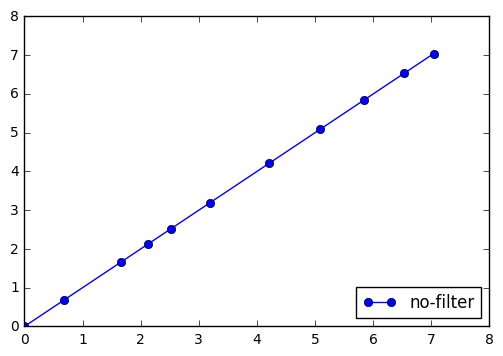

In [9]:
# 随机产生10次运动控制
U = np.random.uniform(low=0.5, high=1.5,size=10)

# 生成无滤波与测量的情况下，机器人对位姿轨迹的估计
X_no_filter = np.array([0, 0, np.pi / 4]).reshape((1,3))
for u in U:
    temp_pose = state_transfer_function(X_no_filter[-1], u)
    X_no_filter = np.vstack([X_no_filter, temp_pose.T])

# 绘制机器人在无滤波的情况下，估计的运动轨迹（忽略了角度值）
fig, ax = plt.subplots()
ax.plot(X_no_filter[:,0], X_no_filter[:,1], c='b', marker='o', label='no-filter')
ax.legend(loc="lower right")

### 3.2 生成具有噪声干扰的机器人真实位姿数据

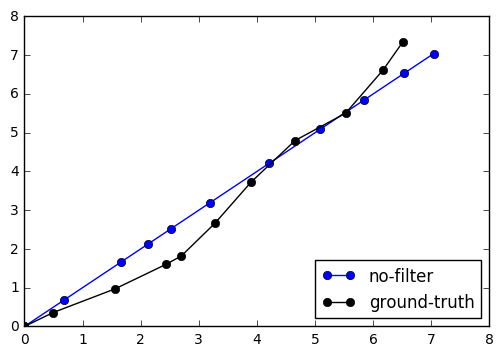

In [10]:
# 假设机器人的控制装置对于移动距离控制的较为精确（方差较大，例如取值为0.3）
# 而对角度的控制较为精确（方差较小，例如取值为0.1）
# 因此采样的协方差矩阵为
Sigma_u = np.diag([0.3**2, 0.3**2, 0.1**2])
X_ground_truth = np.array([0, 0, np.pi / 4]).reshape((1,3))

for u in U:
    temp_pose = state_transfer_sample(X_ground_truth[-1], u, Sigma_u)
    X_ground_truth = np.vstack([X_ground_truth, temp_pose.T])

fig, ax = plt.subplots()
ax.plot(X_no_filter[:,0], X_no_filter[:,1], 
        c='b', marker='o', label='no-filter')
ax.plot(X_ground_truth[:,0], X_ground_truth[:,1], 
        c='k', marker='o', label='ground-truth')
ax.legend(loc="lower right")

从上图可以看出当机器人的控制存在噪声时，真实的位姿轨迹与无滤波的估计之间存在较大的漂移。

### 3.3 根据Ground-Truth数据对测量进行采样

In [11]:
# 假定传感器测量距离世界原点的距离的不确定性为：0.1（标准差）
Sigma_z = 0.1
Z = []

for mu in X_ground_truth:
    z = measurement_sample(mu, Sigma_z)
    Z.append(z)

print(Z)

[array([[ 0.33229995]]), array([[ 0.89515786]]), array([[ 1.83013291]]), array([[ 3.06219283]]), array([[ 3.0598178]]), array([[ 4.12734215]]), array([[ 5.43060441]]), array([[ 6.51301161]]), array([[ 7.80598555]]), array([[ 9.33787122]]), array([[ 9.88809443]])]


### 3.4 用扩展卡尔曼滤波来消除偏差

mu0 [[ 0.          0.          0.78539816]]
Sigma0 [[  1.00000000e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-02   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+02]]
u 0.972653190136
z [[ 0.33229995]]
R [[ 0.0625  0.      0.    ]
 [ 0.      0.0625  0.    ]
 [ 0.      0.      0.0625]]
Q [[ 0.01]]
G [[ 1.          0.         -0.68776967]
 [ 0.          1.          0.68776967]
 [ 0.          0.          1.        ]]
H [[ 0.70710678  0.70710678  0.        ]]
mu1 [[ 0.68776967  0.68776967  0.78539816]]
Sigma1 [[  47.37521141  -47.30271141  -68.77696665]
 [ -47.30271141   47.37521141   68.77696665]
 [ -68.77696665   68.77696665  100.0625    ]]
Temp [[ 12.12121212]]
K [[  6.21396868e-01]
 [  6.21396868e-01]
 [ -1.72252784e-13]]
mu2 [[ 0.28985617]
 [ 0.28985617]
 [ 0.78539816]]
h(mu1) [[ 0.97265319]]
mu0 [[ 0.28985617  0.28985617  0.78539816]]
Sigma0 [[  47.34335535  -47.33456747  -68.77696665]
 [ -47.33456747   47.34335535   68.77696665]
 [ -68.

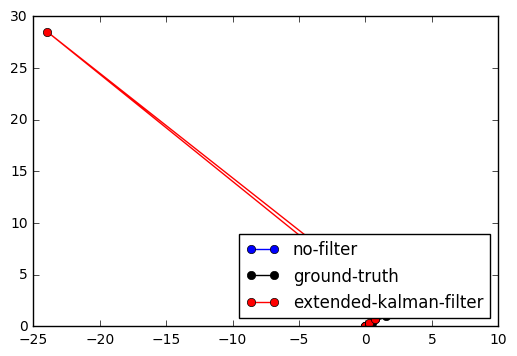

In [27]:
# 假设运动控制误差为0.25，观测误差为0.1
sigma_u = 0.25
sigma_z = 0.1

Sigma = []
# 设定初始的位姿和初始的协方差
X_ekf = np.array([0, 0, np.pi / 4]).reshape((1,3))
sigma = np.diag([0.01, 0.01, 100])
Sigma.append(sigma)

for u, z in zip(U, Z):
    mu, sigma = extended_kalman_filter(X_ekf[-1], Sigma[-1], 
                                       u, z, sigma_u=sigma_u, sigma_z=sigma_z)
    X_ekf = np.vstack([X_ekf, mu.T])
    Sigma.append(sigma)

fig, ax = plt.subplots()
ax.plot(X_no_filter[:,0], X_no_filter[:,1], 
        c='b', marker='o', label='no-filter')
ax.plot(X_ground_truth[:,0], X_ground_truth[:,1], 
        c='k', marker='o', label='ground-truth')
ax.plot(X_ekf[:,0], X_ekf[:,1], 
        c='r', marker='o', label='extended-kalman-filter')
ax.legend(loc="lower right")


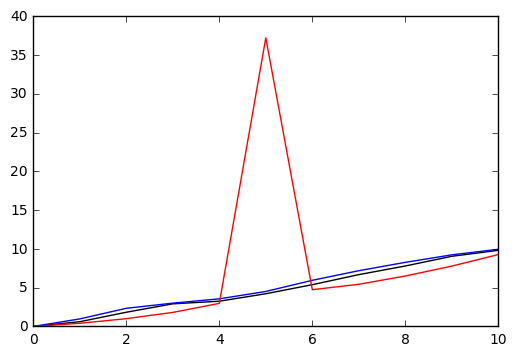

In [13]:
distance_ground_truth = []
distance_no_filter = []
distance_extended_kalman_filter = []

for gt, nf, ekf in zip(X_ground_truth, X_no_filter, X_ekf):
    distance_ground_truth.append(np.sqrt(gt[0]**2 + gt[1] ** 2))
    distance_no_filter.append(np.sqrt(nf[0]**2 + nf[1]**2))
    distance_extended_kalman_filter.append(np.sqrt(ekf[0]**2 + ekf[1]**2))
    
x = [i for i in range(11)]
fig, ax = plt.subplots()
ax.plot(x, distance_ground_truth, c='k')
ax.plot(x, distance_no_filter, c='b')
ax.plot(x, distance_extended_kalman_filter, c='r')

In [14]:
Z

[array([[ 0.33229995]]),
 array([[ 0.89515786]]),
 array([[ 1.83013291]]),
 array([[ 3.06219283]]),
 array([[ 3.0598178]]),
 array([[ 4.12734215]]),
 array([[ 5.43060441]]),
 array([[ 6.51301161]]),
 array([[ 7.80598555]]),
 array([[ 9.33787122]]),
 array([[ 9.88809443]])]